In [ ]:
import codecs
import os
import sys
import threading
import serial
from serial.tools.list_ports import comports

1. Gimbal control

In [10]:
from a2gmeasurements import GimbalRS2
import time, timeit
import numpy as np

myGimbal = GimbalRS2()
myGimbal.start_thread_gimbal()

Start receiving messages


Finding required time for gimbal to answer a position request

In [ ]:
from a2gmeasurements import GimbalRS2
import time, timeit
import numpy as np

myGimbal = GimbalRS2()
myGimbal.start_thread_gimbal()

assumed_time_for_execute_time = 0.0015 # s
gimbal_speed = (1800/3.47) # DEG/s
condition_continue = True
tol = gimbal_speed * assumed_time_for_execute_time
cnt = 0
myGimbal.request_current_position()
time.sleep(0.0015)
last_yaw = myGimbal.yaw 
last_roll = myGimbal.roll
print('Outside: ',last_yaw, last_roll)
myGimbal.setPosControl(yaw=1250, roll=0, pitch=0)
time.sleep(1)
while(condition_continue):
    print('Execution time: ', timeit.default_timer() - start)
    myGimbal.request_current_position()
    time.sleep(0.0015)
    print('Inside: ', myGimbal.yaw, myGimbal.roll)
    
    if np.abs(last_yaw - myGimbal.yaw) < tol and np.abs(last_roll - myGimbal.roll) < tol:
        condition_continue = False
    else:
        last_yaw = myGimbal.yaw
        last_roll = myGimbal.roll
        start = timeit.default_timer()
    cnt = cnt+1
    print(cnt)
    


In [20]:
#myGimbal.request_current_position()
myGimbal.setPosControl(yaw=0, roll=0, pitch=0)

Message sent on PCAN_USBBUS1

Message sent on PCAN_USBBUS1

Message sent on PCAN_USBBUS1

Message sent on PCAN_USBBUS1



True

In [21]:
myGimbal.stop_thread_gimbal()
time.sleep(0.05)
myGimbal.actual_bus.shutdown()

Stopped receiving messages


2. Anritsu Control

In [ ]:
from a2gmeasurements import myAnritsuSpectrumAnalyzer

mySA = myAnritsuSpectrumAnalyzer()
mySA.spectrum_analyzer_connect()
rx_power =  mySA.retrieve_max_pow()
print(rx_power)
mySA.spectrum_analyzer_close()

3. Septentrio Control

In [ ]:
from a2gmeasurements import GpsSignaling
mySeptentrioGPS = GpsSignaling(DBG_LVL_2=True)

In [ ]:
mySeptentrioGPS.serial_connect()
mySeptentrioGPS.serial_instance.reset_input_buffer()


In [ ]:
#mySeptentrioGPS.sendCommandGps(cmd='sga, MultiAntenna') # by default this is the command
mySeptentrioGPS.sendCommandGps(cmd='sgd, ETRS89')
mySeptentrioGPS.sendCommandGps(cmd='spm, Rover, RTK')

In [ ]:
mySeptentrioGPS.sendCommandGps(cmd='setNTRIPSettings, NTR1, Client, opencaster.nls.fi, 2101, fuave, v5E3oKu853A, VRS-FKP')

In [ ]:

#mySeptentrioGPS.start_gps_data_retrieval(msg_type='NMEA', nmea_type='GGA', interval='sec1') # HDF instead of GGA for heading info
#mySeptentrioGPS.start_gps_data_retrieval(msg_type='NMEA', nmea_type='HDT', interval='sec1') # HDF instead of GGA for heading info

mySeptentrioGPS.start_gps_data_retrieval(msg_type='SBF', stream_number=1, interface='USB', interval='sec2')
mySeptentrioGPS.start_thread_gps()


In [ ]:
import struct
struct.calcsize('<1c3H1I1H2B3d5f1d1f4B2H1I2B4H1B')

In [ ]:
mySeptentrioGPS.stop_gps_data_retrieval(msg_type='NMEA')
mySeptentrioGPS.stop_gps_data_retrieval(msg_type='SBF')
mySeptentrioGPS.stop_thread_gps()

In [ ]:
print(len(mySeptentrioGPS.SBF_frame_buffer), len(mySeptentrioGPS.NMEA_buffer))
if len(mySeptentrioGPS.SBF_frame_buffer) > 0:
    print(mySeptentrioGPS.SBF_frame_buffer[-1])
if len(mySeptentrioGPS.NMEA_buffer) > 0:
    print(mySeptentrioGPS.NMEA_buffer[-1])

In [ ]:
mySeptentrioGPS.sendCommandGps('sdio, USB1,, -SBF-NMEA')

In [ ]:
mySeptentrioGPS.serial_instance.close()

In [ ]:
xsbf = mySeptentrioGPS.SBF_frame_buffer[-1]['X']
ybf = mySeptentrioGPS.SBF_frame_buffer[-1]['Y']
zbf = mySeptentrioGPS.SBF_frame_buffer[-1]['Z']

In [ ]:
lat=mySeptentrioGPS.NMEA_buffer[-1]['Latitude']
lon=mySeptentrioGPS.NMEA_buffer[-1]['Longitude']

In [ ]:
print(lat, lon)

In [ ]:
from a2gmeasurements import HelperA2GMeasurements


myHelper = HelperA2GMeasurements(ID=11, SERVER_ADDRESS='')


y, x = myHelper.convert_DDMMS_to_planar(input_lon=lon, 
                                                input_lat=lat, epsg_out=4936)
print(x, y)

Precision of distance when using planar coordinates ('precision' is given by google estimate of distance)

In [ ]:
import pyproj as proj
from a2gmeasurements import HelperA2GMeasurements
import numpy as np

pt_hammentie_50 = [60.186977663598164, 24.961182204780805]
pt_hakaniemi_mkt = [60.17907971164074, 24.951228689442726]

h = HelperA2GMeasurements()

lat_pln_hamm, lon_pln_hamm = h.convert_DDMMS_to_planar(24.961182204780805, 60.186977663598164)
lat_pln_hak, lon_pln_hak = h.convert_DDMMS_to_planar(24.951228689442726, 60.17907971164074)

# Compare this distance with Google MAPS: CHECKED ---> within 2m error
d_hamm_hak = np.linalg.norm(np.array([lon_pln_hamm, lat_pln_hamm]) - np.array([lon_pln_hak, lat_pln_hak]))

Example of a real GPS NMEA output

In [ ]:
real_gps_data = {'Timestamp': '110815.00', 
                 'Latitude': '6011.1011606', 
                 'Latitude Direction': 'N', 
                 'Longitude': '02448.9144475', 
                 'Longitude Direction': 'E', 
                 'GPS Quality Indicator': '2', 
                 'Number of Satellites in use': '28', 
                 'Horizontal Dilution of Precision': '0.6', 
                 'Antenna Alt above sea level (mean)': '0.9230', 
                 'Units of altitude (meters)': 'M', 
                 'Geoidal Separation': '19.5883', 
                 'Units of Geoidal Separation (meters)': 'M', 
                 'Age of Differential GPS Data (secs)': '1.8', 
                 'Differential Reference Station ID': '0123'}

real_gps_sbf_data = {'TOW': 476864000, 'WNc': 2237, 'MODE': 1, 'ERR': 0, 
                     'X': 2885666.3154522795, 'Y': 1334484.5807205061, 'Z': 5510775.657593954, 
                     'Undulation': 19.586938858032227, 
                     'Vx': -0.0005603009485639632, 'Vy': 0.013242623768746853, 'Vz': 0.0013509213458746672, 
                     'COG': -20000000000.0, 'RxClkBias': 0.1324483297937943, 'RxClkDrift': 0.019449610263109207, 
                     'TimeSystem': 0, 'Datum': 0, 'NrSV': 12, 'WACorrInfo': 0, 'ReferenceID': 65535, 
                     'MeanCorrAge': 65535, 'SignalInfo': 807534857, 'AlertFlag': 1, 'NrBases': 0, 
                     'PPPInfo': 0, 'Latency': 64, 'HAccuracy': 1500, 'VAccuracy': 1471}

Server connection

In [ ]:
from socket import socket
import time
from a2gmeasurements import HelperA2GMeasurements

host = 'localhost'
myHelper = HelperA2GMeasurements('GROUND', host)
myHelper.HelperStartA2GCom()


In [ ]:
myHelper.HelperA2GStopCom()
print(myHelper.SOCKET_BUFFER, len(myHelper.SOCKET_BUFFER))

5. Signal generator

In [ ]:
import pyvisa

rm = pyvisa.ResourceManager()
print(rm.list_resources())

inst = rm.open_resource('GPIB0::19::INSTR')
print(inst.query("*IDN?"))

inst.write('F0 28.95 GH\n')
inst.write('L0 20 DM\n')

# Turn On RF output
inst.write('RF1\n')
# Turn Off RF output
inst.write('RF0\n')

In [ ]:
from a2gmeasurements import myAnritsuSpectrumAnalyzer

dir = 'C://Users//jvjulian//OneDrive - Teknologian Tutkimuskeskus VTT//Documents//Measurement 1//20221012133438//'
file = 'CONT20221012133504968.rsm'

anritsu = myAnritsuSpectrumAnalyzer()
anritsu.parse_xml_file(dir + file)
anritsu.XML_file

In [ ]:
from PyQt6.QtWidgets import QApplication, QLabel, QWidget
import sys

app = QApplication([])

window = QWidget()
window.setWindowTitle("PyQt App")
window.setGeometry(100, 600, 280, 280) # 1st: x coordinate, 2nd: y coordinate, 3rd: width, 4th: height
helloMsg = QLabel("<h1>Hello World</h1>", parent=window)
helloMsg.move(60, 15)
window.show()

sys.exit(app.exec())


In [ ]:
import datetime
import time
import sys

today_date = datetime.date.today()
today_date = [int(i) for i in today_date.strftime("%Y-%m-%d").split('-')]

ex = '110815.00'

print(today_date)

complete_date = datetime.datetime(year=today_date[0], 
                                  month=today_date[1], 
                                  day=today_date[2], 
                                  hour=int(ex[0:2]), 
                                  minute=int(ex[2:4]), 
                                  second=int(ex[4:6]))

a = time.mktime(complete_date.timetuple())
print(a)

print(time.time())

Animation to prove gimbal_follows_drone function does its job

c:\Users\jvjulian\MyInstalledPrograms\envs\gimbalRS2\lib\site-packages\matplotlib\animation.py:879: UserWarning: Animation was deleted without rendering anything. This is most likely not intended. To prevent deletion, assign the Animation to a variable, e.g. `anim`, that exists until you output the Animation using `plt.show()` or `anim.save()`.
  warnings.warn(


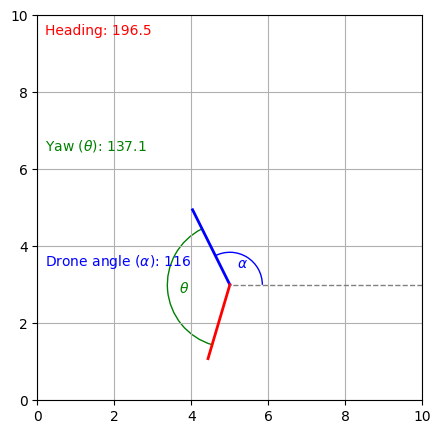

In [19]:
import numpy as np
from matplotlib import pyplot as plt
from matplotlib import animation
from matplotlib.animation import PillowWriter
from a2gUtils import AngleAnnotation
from a2gmeasurements import HelperA2GMeasurements


myHelper = HelperA2GMeasurements(ID='GROUND', SERVER_ADDRESS='')

xlim = (0, 10)
ylim = (0, 10)

lon_ground_planar = (xlim[0] + xlim[1])/2
lat_ground_planar = 3
height_ground = 1

fig = plt.figure(figsize=((5, 5)))
ax = fig.add_subplot(111, aspect='equal', xlim=xlim, ylim=ylim)

ax.grid()


line1, = ax.plot([],[], lw=2, color='blue')
line2, = ax.plot([],[], lw=2, color='red')
line3, = ax.plot([],[], lw=1, color='gray', linestyle='--')
heading_angle_text = ax.text(0.02, 0.95, '', transform=ax.transAxes, color='red')
yaw2set_text = ax.text(0.02, 0.65, '', transform=ax.transAxes, color='green')
angle_drone_wrt_horizontal_text = ax.text(0.02, 0.35, '', transform=ax.transAxes, color='blue')

def animate(i):
    lon_drone_planar = np.random.rand()*10
    lat_drone_planar = np.random.rand()*10
    
    heading = np.random.rand()*np.pi*2
      
    yaw, _, alpha = myHelper.ground_gimbal_follows_drone(heading=heading, 
                                                   lat_ground=lat_ground_planar, 
                                                   lon_ground=lon_ground_planar, 
                                                   height_ground=1, 
                                                   lat_drone=lat_drone_planar, 
                                                   lon_drone=lon_drone_planar, 
                                                   height_drone=10, 
                                                   coord_type='planar')
    
    line1.set_data([lon_drone_planar, lon_ground_planar], 
                  [lat_drone_planar, lat_ground_planar])
    
    if heading > np.pi:
        heading_wrt_long_axs = np.pi/2 - (heading - np.pi*2)
        if heading_wrt_long_axs > np.pi:
            heading_wrt_long_axs = heading_wrt_long_axs - np.pi*2
        elif heading_wrt_long_axs < -np.pi:
            heading_wrt_long_axs = heading_wrt_long_axs + np.pi*2
    else:
        heading_wrt_long_axs = np.pi/2 - heading
        if heading_wrt_long_axs > np.pi:
            heading_wrt_long_axs = heading_wrt_long_axs - np.pi*2
        elif heading_wrt_long_axs < -np.pi:
            heading_wrt_long_axs = heading_wrt_long_axs + np.pi*2
    
    x_heading = lon_ground_planar + 2*np.cos(heading_wrt_long_axs)
    y_heading = lat_ground_planar + 2*np.sin(heading_wrt_long_axs)
    
    line2.set_data([x_heading, lon_ground_planar], 
                   [y_heading, lat_ground_planar])
        
    heading_angle_text.set_text('Heading: %.1f' % np.rad2deg(heading))
    yaw2set_text.set_text('Yaw (' +  r"$\theta$"  + '): '  +  f"{float(yaw)/10}")
    angle_drone_wrt_horizontal_text.set_text('Drone angle (' + r"$\alpha$"  + '): ' + f"{int(np.rad2deg(alpha))}")
    
    if yaw > 0:
        am1 = AngleAnnotation((lon_ground_planar, lat_ground_planar), 
                          (lon_drone_planar, lat_drone_planar), (x_heading, y_heading),  
                          ax=ax, size=125, text=r"$\theta$", color='green', text_kw=dict(color="green"))
    else:
        am1 = AngleAnnotation((lon_ground_planar, lat_ground_planar), 
                          (x_heading, y_heading), (lon_drone_planar, lat_drone_planar), 
                          ax=ax, size=125, text=r"$\theta$", color='green', text_kw=dict(color="green"))
        
    if alpha > 0:        
        am2 = AngleAnnotation((lon_ground_planar, lat_ground_planar), 
                          (xlim[1], lat_ground_planar), (lon_drone_planar, lat_drone_planar),
                          ax=ax, size=65, text=r"$\alpha$", color='blue', text_kw=dict(color="blue"))
    else:
        am2 = AngleAnnotation((lon_ground_planar, lat_ground_planar), 
                          (lon_drone_planar, lat_drone_planar), (xlim[1], lat_ground_planar),
                          ax=ax, size=65, text=r"$\alpha$", color='blue', text_kw=dict(color="blue"))
    
    line3.set_data([xlim[1], lon_ground_planar], 
                   [lat_ground_planar, lat_ground_planar])
    
    return line1, line2, heading_angle_text, yaw2set_text

ani = animation.FuncAnimation(fig, animate, frames=10, interval=5, repeat=False)

ani.save('basic_animation_2.gif', dpi=300, writer=PillowWriter(fps=0.2))
#plt.show()

In [11]:
from pyproj import CRS, Transformer

a = {'X': 2885666.3154522795, 'Y': 1334484.5807205061, 'Z': 5510775.657593954}

geodet_crs = CRS.from_epsg(4979) # Geodetic (lat,lon,h) system
geocent_crs = CRS.from_epsg(4978) # Geocentric (X,Y,Z) system

# pyproj transformer object from geocentric to geodetic
geocent_to_geodet = Transformer.from_crs(geocent_crs, geodet_crs)


lat_lon = geocent_to_geodet.transform(a['X'],a['Y'],a['Z'])

print(lat_lon)

(60.184648143207625, 24.818315331415892, 47.33474831096828)


In [ ]:
import datetime
gps_data = {}
gps_data['Timestamp'] = ''
for i in datetime.datetime.utcnow().timetuple()[3:6]:
    tmp = str(i)
    if len(tmp) == 1:
        tmp = '0' + tmp
    gps_data['Timestamp'] = gps_data['Timestamp'] + tmp
gps_data['Timestamp'] = float(int(gps_data['Timestamp']))
print(gps_data)

In [17]:
import json
a = {'CMD_SOURCE': 'SETGIMBAL', 'TYPE': 'CMD', 'DATA': {'YAW': 1245.5, 'PITCH': -614}}
a = json.dumps(a)


b = json.loads(a)
b['DATA']['YAW']

     
     

1245.5